In [2]:
!pip install cantera

In [3]:
# -*- coding: utf-8 -*-
"""

The PFR 

"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#######################################################################
# Input Parameters
#######################################################################
cantera_folder = '/home/navedanan/Code/runs/alonx1002/chemkin/species_dictionary.txt'
T_0 = 1500.0  # inlet temperature [K]
pressure = ct.one_atm  # constant pressure [Pa]
composition_0 = 'C12H26(1):1'
length = 1e-5  # *approximate* PFR length [m]
u_0 = .006  # inflow velocity [m/s]
area = 1.e-4  # cross-sectional area [m**2]

# input file containing the reaction mechanism
reaction_mechanism = '/home/navedanan/Code/runs/alonx1002/chemkin/chem_annotated.cti'

# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain
# of 'n_steps' stirred reactors.
n_steps = 2000
#####################################################################


#####################################################################
# Method 1: Lagrangian Particle Simulation
#####################################################################
# A Lagrangian particle is considered which travels through the PFR. Its
# state change is computed by upwind time stepping. The PFR result is produced
# by transforming the temporal resolution into spatial locations.
# The spatial discretization is therefore not provided a priori but is instead
# a result of the transformation.

# import the gas model and set the initial conditions
gas1 = ct.Solution(reaction_mechanism)
gas1.TPX = T_0, pressure, composition_0
mass_flow_rate1 = u_0 * gas1.density * area

# create a new reactor
r1 = ct.IdealGasConstPressureReactor(gas1)
# create a reactor network for performing time integration
sim1 = ct.ReactorNet([r1])

# approximate a time step to achieve a similar resolution as in the next method
t_total = length / u_0
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt 
z1 = np.zeros_like(t1)
u1 = np.zeros_like(t1)
states1 = ct.SolutionArray(r1.thermo)
for n1, t_i in enumerate(t1):
    # perform time integration
    sim1.advance(t_i)
    # compute velocity and transform into space
    u1[n1] = mass_flow_rate1 / area / r1.thermo.density
    z1[n1] = z1[n1 - 1] + u1[n1] * dt
    states1.append(r1.thermo.state)
#####################################################################


#####################################################################
# Method 2: Chain of Reactors
#####################################################################
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.
# (This approach is anologous to the one presented in 'surf_pfr.py', which
# additionally includes surface chemistry)


# import the gas model and set the initial conditions
gas2 = ct.Solution(reaction_mechanism)
gas2.TPX = T_0, pressure, composition_0
mass_flow_rate2 = u_0 * gas2.density * area
dz = length / n_steps
r_vol = area * dz

# create a new reactor
r2 = ct.IdealGasReactor(gas2)
r2.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas2, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas2, name='downstream')

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r2, mdot=mass_flow_rate2)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r2, downstream, master=m, K=1e-5)

sim2 = ct.ReactorNet([r2])

# define time, space, and other information vectors
z2 = (np.arange(n_steps) + 1) * dz
t_r2 = np.zeros_like(z2)  # residence time in each reactor
u2 = np.zeros_like(z2)
t2 = np.zeros_like(z2)
states2 = ct.SolutionArray(r2.thermo)
# iterate through the PFR cells
for n in range(n_steps):
    # Set the state of the reservoir to match that of the previous reactor
    gas2.TDY = r2.thermo.TDY
    upstream.syncState()
    # integrate the reactor forward in time until steady state is reached
    sim2.reinitialize()
    sim2.advance_to_steady_state()
    # compute velocity and transform into time
    u2[n] = mass_flow_rate2 / area / r2.thermo.density
    t_r2[n] = r2.mass / mass_flow_rate2  # residence time in this reactor
    t2[n] = np.sum(t_r2)
    # write output data
    states2.append(r2.thermo.state)

#####################################################################

#####################################################################
# Sorting the double bond moleculs 
#####################################################################

from rmgpy.chemkin import load_species_dictionary


chem_path = '/home/navedanan/Code/runs/alonx1002/chemkin/chem_anotated.inp'  # Chemkin input file
dict_path = '/home/navedanan/Code/runs/alonx1002/chemkin/species_dictionary.txt'


species_dict = load_species_dictionary(dict_path)

alkene_labels = list()
alkane_labels = list()
cut_alkane_labels = list ()
for label, species in species_dict.items():
    if any(bond.order == 2 for bond in species.molecule[0].get_all_edges()):
        alkene_labels.append(label)
        #display(species)
    else:
        alkane_labels.append(label)
        cut_alkane_labels.append(label)

# del cut_alkane_labels[7]
# del cut_alkane_labels[5]

#####################################################################


#####################################################################
# Compare Results in matplotlib
#####################################################################

# plt.figure(2)
# for i in range (3,len(cut_alkane_labels),1):
#     plt.plot(t1, states1.X[:, gas1.species_index(cut_alkane_labels[i])], label=cut_alkane_labels[i])
# plt.xlabel('$t$ [s]')
# plt.ylabel('$Mol_frac.$ [-]')
# plt.title("Mol frac. VS Time")
# plt.legend(loc=0)
# plt.legend(bbox_to_anchor=(1.1, 1.05))

# plt.figure(3)
# for i in range (3,len(alkane_labels),1):
#     plt.plot(t1, states1.X[:, gas1.species_index(alkane_labels[i])], label=alkane_labels[i])
# #plt.plot(t2, states2.X[:, gas2.species_index('H2(23)')], label='Reactor Chain')
# plt.xlabel('$t$ [s]')
# plt.ylabel('$Mol_frac.$ [-]')
# plt.title("Mol frac. VS Time")
# plt.legend(loc=0)
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.savefig('pfr_T_z.png')

# plt.figure(4)
# plt.plot(t1, sumfrac, label='Ethane')

# plt.show()
# plt.savefig('pfr_XH2_t.png')
# gas1()
# print(alkene_labels)
# print("#######")
# print(alkane_labels)
# print("#######")
# print(cut_alkane_labels)
print("states1 loaded")

CanteraError: 
***********************************************************************
CanteraError thrown by ct2ctml_string:
Error converting input file "/home/navedanan/Code/runs/alonx1002/chemkin/chem_annotated.cti" to CTML.
Python command was: '/home/navedanan/anaconda3/envs/rmg_env/bin/python'
The exit code was: 7
-------------- start of converter log --------------
Python 3.7.11 (default, Jul 27 2021, 14:35:47) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)
Traceback (most recent call last):
  File "<console>", line 8, in <module>
  File "/home/navedanan/anaconda3/envs/rmg_env/lib/python3.7/site-packages/cantera/ctml_writer.py", line 2694, in convert
    write(outName)
  File "/home/navedanan/anaconda3/envs/rmg_env/lib/python3.7/site-packages/cantera/ctml_writer.py", line 377, in write
    x.write(sys.stdout)
  File "/home/navedanan/anaconda3/envs/rmg_env/lib/python3.7/site-packages/cantera/ctml_writer.py", line 152, in write
    filename.write(''.join(s))
BlockingIOError: [Errno 11] write could not complete without blocking
--------------- end of converter log ---------------
***********************************************************************


In [ ]:
def alkenes_list(): #find and put together all the alkenes species
    from rmgpy.chemkin import load_species_dictionary


    chem_path = '/home/navedanan/Code/runs/alonx1002/chemkin/chem_anotated.inp'  # Chemkin input file
    dict_path = '/home/navedanan/Code/runs/alonx1002/chemkin/species_dictionary.txt'


    species_dict = load_species_dictionary(dict_path)

    alkene_labels = list()
    alkene_molfrac = list()
    alkene_labels = list()
    cut_alkane_labels = list ()
    
    for label, species in species_dict.items():
        if any(bond.order == 2 for bond in species.molecule[0].get_all_edges()):
            alkene_labels.append(label)
            
        else:
            alkane_labels.append(label)
    return alkene_labels , alkane_labels

    # del cut_alkane_labels[7]
    # del cut_alkane_labels[5]

def alkenes_total_fraction_to_pfr(): # list that contain total alkenes mol fraction over time
    sumfrac = np.zeros(len(states1.X[:, gas1.species_index('C12H26(1)')]))
    for m in alkene_labels:
        for n in range (0, len(states1.X[:, gas1.species_index('C12H26(1)')]), 1):
            sumfrac[n] += states1.X[:, gas1.species_index(m)][n]
    return sumfrac

def alkenes_total_fraction_to_sensitivity(): # list that contain total alkenes mol fraction over time
    sumfrac2 = np.zeros(len(states('C12H26(1)').X))
    for m in alkene_labels:
        print(m)
        for n in range (0, len(states('C12H26(1)').X), 1):
            sumfrac2[n] += states(m).X[n]
    return sumfrac2

alkene_mol_frac = alkenes_total_fraction_to_pfr()
alkene_mol_frac2 = alkenes_total_fraction_to_sensitivity()


### קוד לאנליזת רגישות ונתוני אחוז מולרי כתלות בזמן (1)

For species C9H18(137), discontinuity in h/RT detected at Tmid = 1391.0
	Value computed using low-temperature polynomial:  27.522869828700813
	Value computed using high-temperature polynomial: 27.456200375127338

the final X of hydrogen is: [0.00922172] and for methane is [0.02015063]


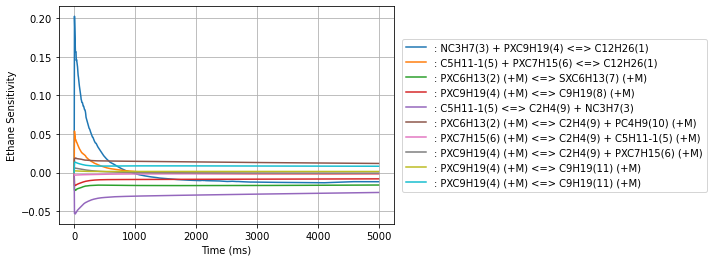

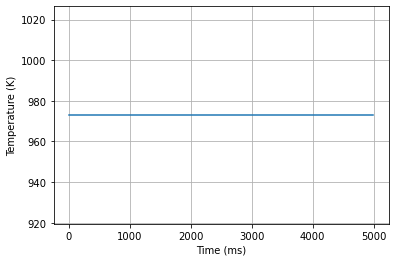

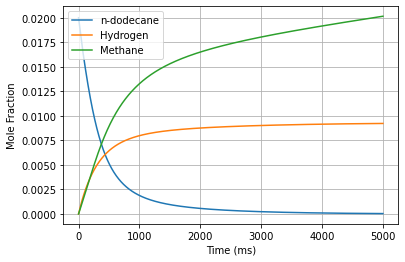

In [2]:
"""
sensitivity analysis

"""

import sys
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
%matplotlib inline
gas = ct.Solution('/home/navedanan/Code/runs/alonx1002/test/chem_annotated.cti')
temp = 973.0
pres = ct.one_atm

gas.TPX = temp, pres, 'C12H26(1):0.02, Ar:0.98'
r = ct.IdealGasConstPressureReactor(gas, energy='off', name='')
sim = ct.ReactorNet([r])



# enable sensitivity with respect to the rates of the first 21
# reactions (reactions 0 through 20)
for i in range(11):
    r.add_sensitivity_reaction(i)

# set the tolerances for the solution and for the sensitivity coefficients
sim.rtol = 1.0e-6
sim.atol = 1.0e-15
sim.rtol_sensitivity = 1.0e-6
sim.atol_sensitivity = 1.0e-6

states = ct.SolutionArray(gas, extra=['t', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                                      's9', 's10'])
reaction_ls = gas.reactions()
for t in np.arange(0, 5e-0, 5e-3):
    sim.advance(t)
    s1 = sim.sensitivity('H2(23)', 1)  # sensitivity of ethane to reaction 1
    s2 = sim.sensitivity('H2(23)', 2)  # sensitivity of ethane to reaction 2
    s3 = sim.sensitivity('H2(23)', 3)  # sensitivity of ethane to reaction 3
    s4 = sim.sensitivity('H2(23)', 4)  # sensitivity of ethane to reaction 4
    s5 = sim.sensitivity('H2(23)', 5)  # sensitivity of ethane to reaction 5
    s6 = sim.sensitivity('H2(23)', 6)  # sensitivity of ethane to reaction 6
    s7 = sim.sensitivity('H2(23)', 7)  # sensitivity of ethane to reaction 7
    s8 = sim.sensitivity('H2(23)', 8)  # sensitivity of ethane to reaction 8
    s9 = sim.sensitivity('H2(23)', 9)  # sensitivity of ethane to reaction 9
    s10 = sim.sensitivity('H2(23)', 10)  # sensitivity of ethane to reaction 10


    states.append(r.thermo.state, t=1000*t, s1=s1, s2=s2, s3=s3, s4=s4,
                  s5=s5, s6=s6, s7=s7, s8=s8, s9=s9, s10=s10,)
##### Plot Desigh #####
plt.tight_layout()
plt.figure(1)
plt.plot(states.t, states.s1, states.t, states.s2, states.t, states.s3, states.t, states.s4,
         states.t, states.s5, states.t, states.s6, states.t, states.s7, states.t, states.s8,
         states.t, states.s9, states.t, states.s10)
plt.legend([sim.sensitivity_parameter_name(1), sim.sensitivity_parameter_name(2),
           sim.sensitivity_parameter_name(3), sim.sensitivity_parameter_name(4),
           sim.sensitivity_parameter_name(5), sim.sensitivity_parameter_name(6),
           sim.sensitivity_parameter_name(7), sim.sensitivity_parameter_name(8),
           sim.sensitivity_parameter_name(9), sim.sensitivity_parameter_name(10)
           ], loc='center left', bbox_to_anchor=(1.01, 0.5) )
plt.xlabel('Time (ms)')
plt.ylabel('Ethane Sensitivity')
plt.grid()
plt.savefig('/home/navedanan/Code/runs/alonx1002/Graphs/20NDDSensitivityAnalysis4.png',bbox_inches='tight')

plt.figure(2)
plt.plot(states.t, states.T)
plt.xlabel('Time (ms)')
plt.ylabel('Temperature (K)')
plt.grid()
# plt.savefig('/home/navedanan/Code/runs/alonx1002/Graphs/NDDTempVsTime.png',bbox_inches='tight')

plt.figure(3)
plt.plot(states.t, states('C12H26(1)').X)
plt.plot(states.t, states('H2(23)').X)
plt.plot(states.t, states('CH4(28)').X)

plt.legend(['n-dodecane', 'Hydrogen', 'Methane'])
plt.xlabel('Time (ms)')
plt.ylabel('Mole Fraction')
plt.grid()
print(f"the final X of hydrogen is: {states('H2(23)').X[-1]} and for methane is {states('CH4(28)').X[-1]}")



### קוד להשוואת נתונים ספרותיים לערכים שהתקבלו במודל

In [ ]:
! pip install xlrd # run this line if 'xlrd' is not installed

Text(0.5, 0, 'Time [mSec]')

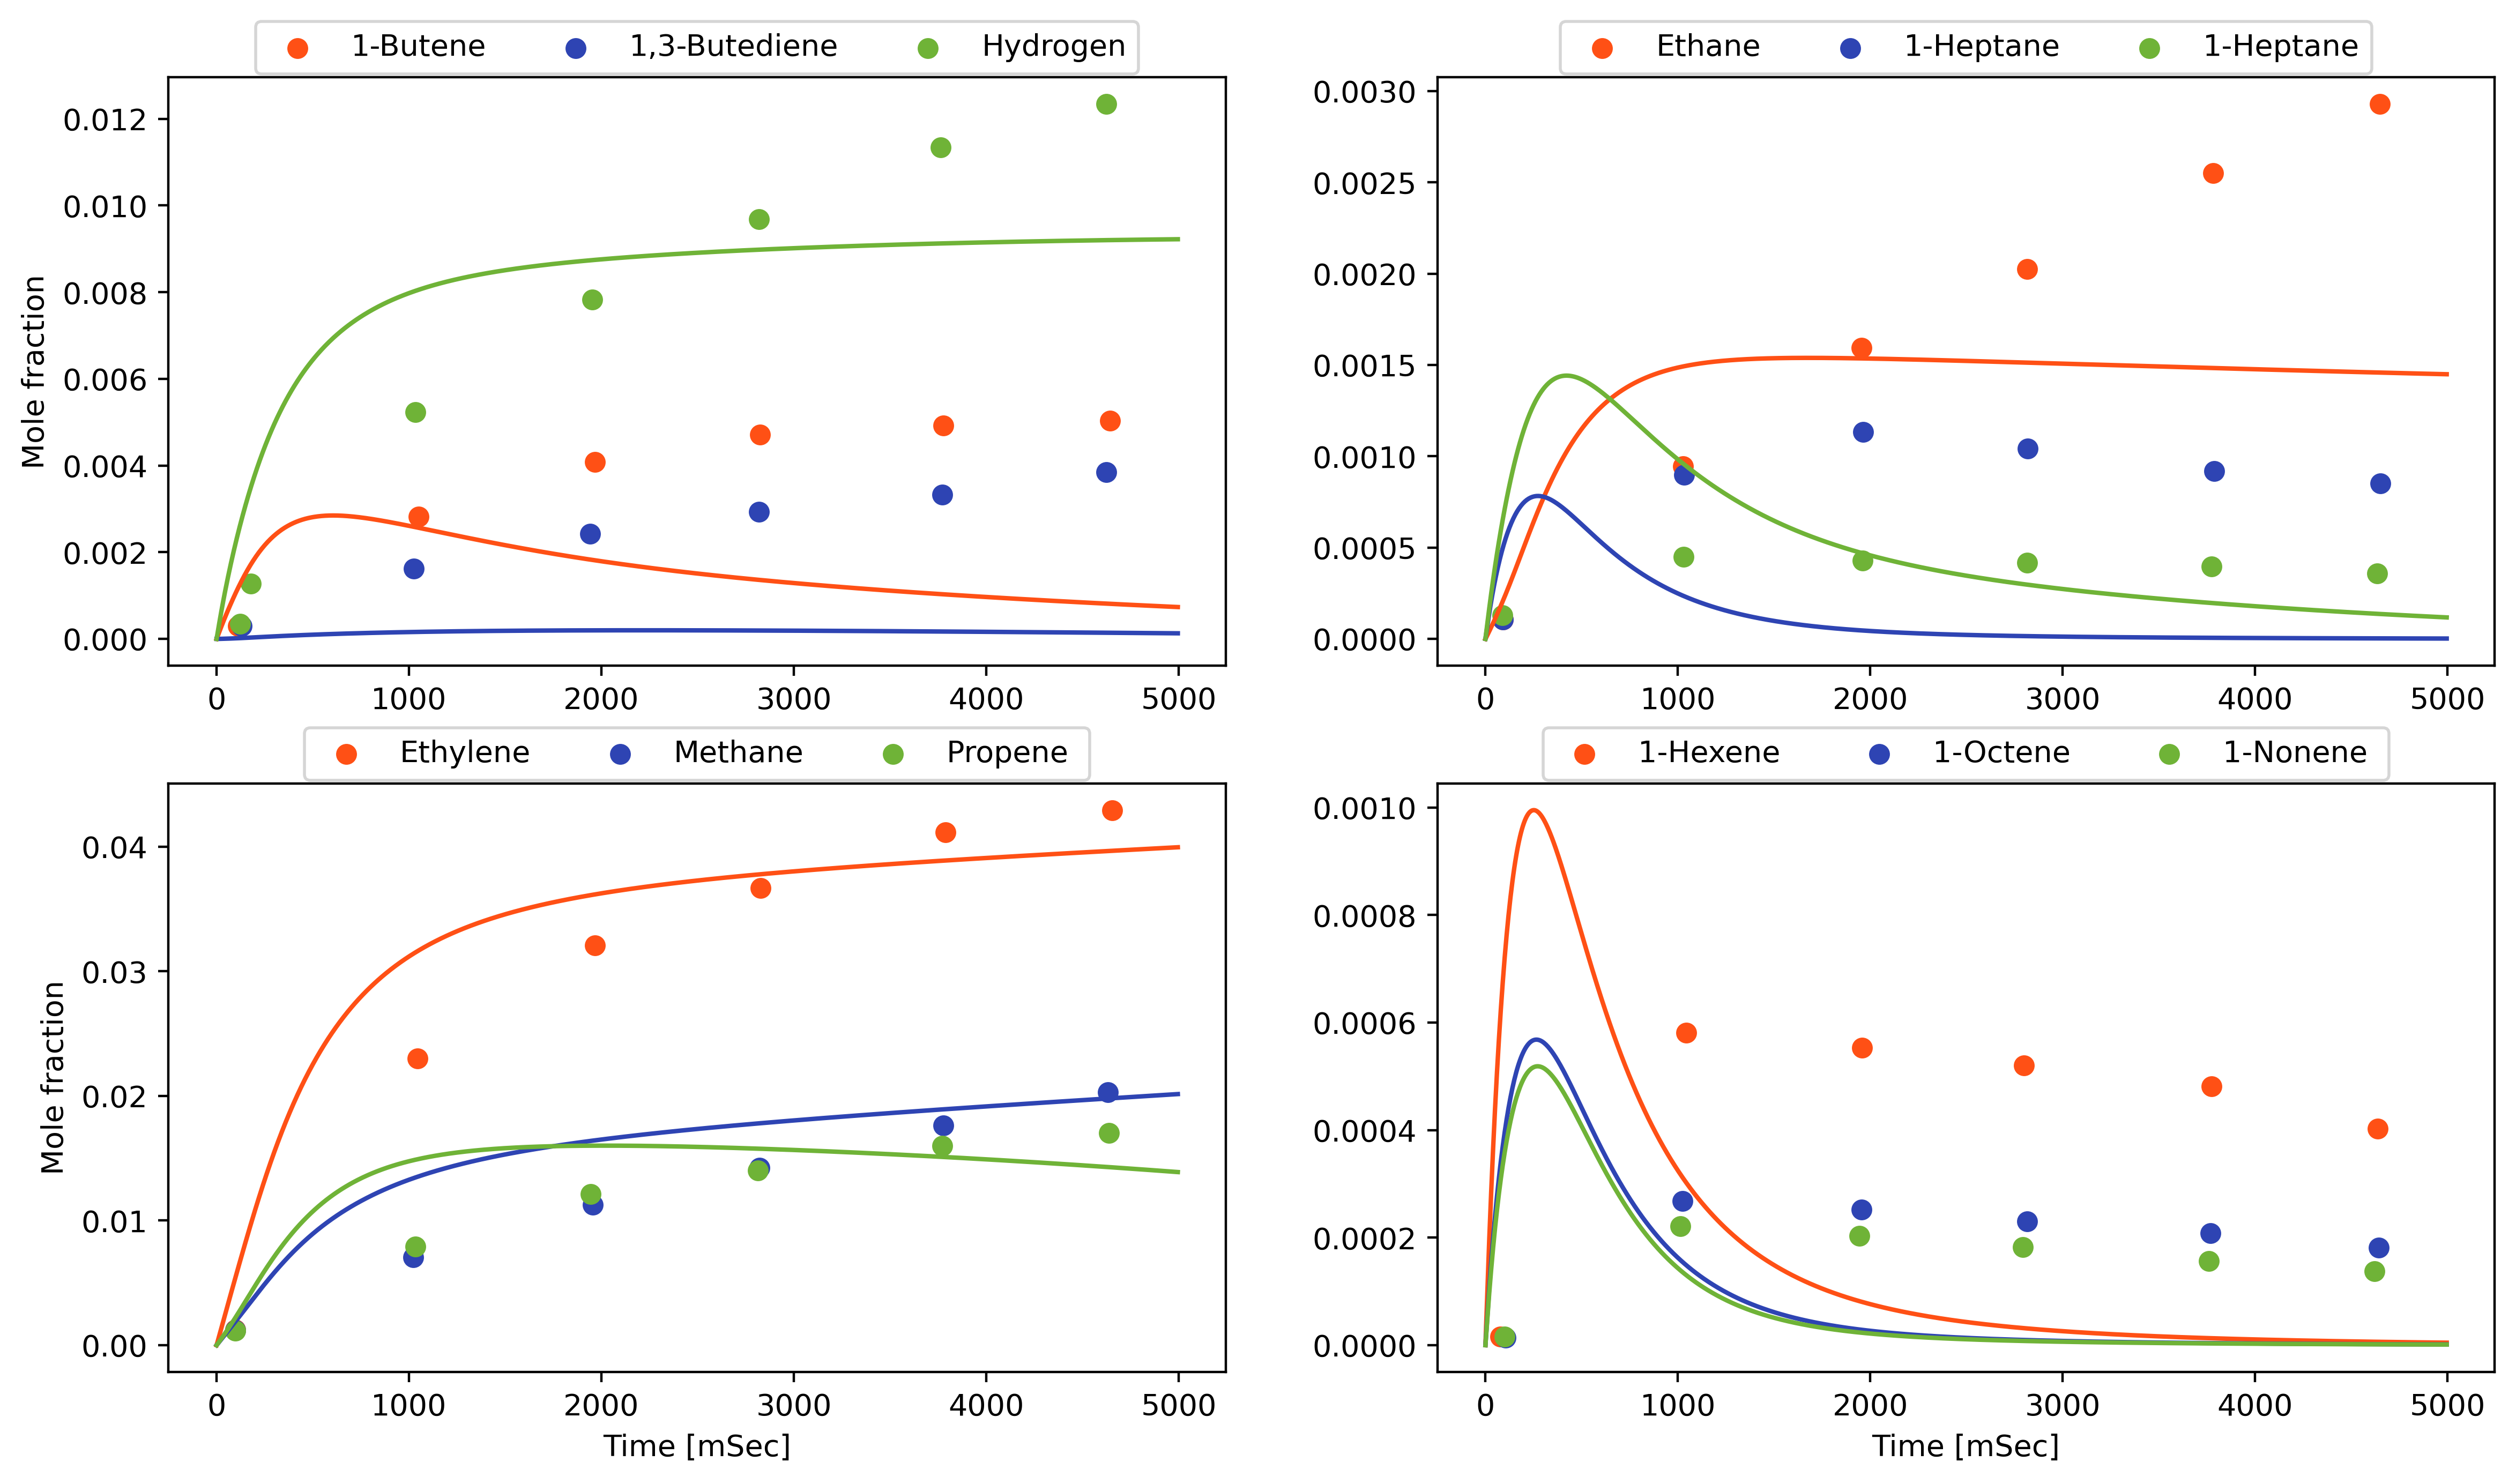

In [3]:
from pandas import ExcelWriter, ExcelFile, read_excel
import matplotlib.pyplot as plt
excel_file = ExcelFile('/home/navedanan/Downloads/All_plots.xls') #Path to the csv file
df1 = read_excel(excel_file, '1') #Path to the csv file1
df2 = read_excel(excel_file, '2') #Path to the csv file2
df3 = read_excel(excel_file, '3') #Path to the csv file3
df4 = read_excel(excel_file, '4') #Path to the csv file4

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,8), dpi=400)
ax1.scatter(df1['X_1-butene ']*1000, df1['Y_1-butene '], label='1-Butene',color="#FF5015")
ax1.plot(states.t, states('C4H8-1(21)').X,color="#FF5015")
ax1.scatter(df1['X_3-butediene ']*1000, df1['Y_3-butediene '], label='1,3-Butediene',color="#2E44B3")
ax1.plot(states.t, states('C4H6(61)').X,color="#2E44B3")
ax1.scatter(df1['X_H2 ']*1000, df1['Y_H2 '], label='Hydrogen',color="#6FB337")
ax1.plot(states.t, states('H2(23)').X,color="#6FB337")
ax1.legend(loc='upper center', ncol=3 , bbox_to_anchor=(0.5, 1.12))

ax1.set_ylabel('Mole fraction')

ax2.scatter(df2['x_ethane']*1000, df2['Y_ethane '], label='Ethane',color="#FF5015")
ax2.plot(states.t, states('C2H6(38)').X,color="#FF5015")
ax2.scatter(df2['X_1-heptene ']*1000, df2['Y_1-heptene '], label='1-Heptane',color="#2E44B3")
ax2.plot(states.t, states('C7H14(25)').X,color="#2E44B3")
ax2.scatter(df2['X_1-pentene ']*1000, df2['Y_1-pentene '], label='1-Heptane',color="#6FB337")
ax2.plot(states.t, states('C5H10(20)').X ,color="#6FB337")
ax2.legend(loc='upper center', ncol=3 , bbox_to_anchor=(0.5, 1.12))


ax3.scatter(df3['X_ethylene ']*1000, df3['Y_ethylene '], label='Ethylene',color="#FF5015")
ax3.plot(states.t, states('C2H4(9)').X,color="#FF5015")
ax3.scatter(df3['X_methane ']*1000, df3['Y_methane '], label='Methane',color="#2E44B3")
ax3.plot(states.t, states('CH4(28)').X,color="#2E44B3")
ax3.scatter(df3['X_propene ']*1000, df3['Y_propene '], label='Propene ' ,color="#6FB337")
ax3.plot(states.t, states('C3H6(17)').X ,color="#6FB337")
ax3.legend(loc='upper center', ncol=3 , bbox_to_anchor=(0.5, 1.12))
ax3.set_xlabel('Time [mSec]')
ax3.set_ylabel('Mole fraction')

ax4.scatter(df4['X_1-hexene ']*1000, df4['Y_1-hexene '], label='1-Hexene ',color="#FF5015")
ax4.plot(states.t, states('C6H12(18)').X,color="#FF5015")
ax4.scatter(df4['X_1-octene ']*1000, df4['Y_1-octene '], label='1-Octene ',color="#2E44B3")
ax4.plot(states.t, states('C8H16(36)').X,color="#2E44B3")
ax4.scatter(df4['X_1-nonene ']*1000, df4['Y_1-nonene '], label='1-Nonene ' ,color="#6FB337")
ax4.plot(states.t, states('C9H18(35)').X ,color="#6FB337")
ax4.legend(loc='upper center', ncol=3 , bbox_to_anchor=(0.5, 1.12))
ax4.set_xlabel('Time [mSec]')


